In [1]:
import os
import h5py
import numpy as np
from scipy.signal import butter, filtfilt

from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

## Single Subject Baseline Analysis

Do analysis on four subjects, and run on the file `S{s}_F_CL_Sil_50_100.mat` for `s`=`01`, `02`, `03`, `05`.  

### 0. Define Initial Parameters

In [31]:
# Specify the folder path relative to the current directory
folder_path = "Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight"

# Specify subjects
subjects = ['01', '02', '03', '05']

# Specify file paths
file_paths = []
for s in subjects:
    file_path = os.path.join(folder_path, f"S{s}_F_CL_Sil_50_100.mat")
    file_paths.append(file_path)

# Parameters
sampling_rate = 256 # Hz

# Define frequency bands
frequency_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 25),
    "Gamma": (25, 100)
}

# Initialize classifiers
classifiers = {
        "LDA": LinearDiscriminantAnalysis(),
        "SVM": SVC(kernel='linear', random_state=42),
        "LogisticRegression": LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    }

### 1. Extract Trials (Epoching)

Given a raw data file (within-subject data), extract the 12 easy and 12 hard trials for the subject. Note that some trials may be skipped due to invalid data structure. 

In short, extract the first 30 seconds of the easy trials data, and the last 30 seconds of the hard trials data.

We should obtain two arrays, one for easy trials and one for hard trials, each with shape `(n_trials=12, n_channels=64, n_features=t_seconds * sampling_rate=30*256)`

In [32]:
def extract_trials(filepath, sampling_frequency = 256, sample_duration = 30, downsample_rate = 1):
    with h5py.File(filepath, 'r') as f:
        raw_eeg_data = np.array(f['actualVariable']['EEG_full']['data']).T[:64]
        events = f['actualVariable']['EEG_full']['event']
        event_labels = []
        
        for i in range(len(events['type'])):
            event_type_ref = events['type'][i][0]
            event_latency_ref = events['latency'][i][0]
            
            event_type = ''.join(chr(x) for x in f[event_type_ref][:].flatten())
            event_latency = f[event_latency_ref][()][0]
            event_labels.append((event_type, event_latency))
        
        easy_data_list = []
        hard_data_list = []
        
        trial_starts = []
        trial_ends = []
        
        for event, time in event_labels:
            if event == "START-F_CL_Sil_50_100":
                trial_starts.append(time)
            elif event == "boundary":
                trial_ends.append(time)
        trial_ends.append(event_labels[-1][1])
        
        num_trials = len(trial_starts)
        for trial_idx in range(num_trials):
            start_time = trial_starts[trial_idx]
            end_time = trial_ends[trial_idx]
            start_sample = int(start_time)
            end_sample = int(end_time)
            
            trial_data = raw_eeg_data[:, start_sample:end_sample]
            trial_duration = end_time - start_time
            num_samples_in_trial = trial_data.shape[1]
            
            if trial_idx % 2 == 0:
                data_segment = trial_data[:, :sample_duration*sampling_frequency]
                if np.shape(data_segment)[1] != sample_duration*sampling_frequency:
                    print("skipped trial")
                    continue
                data_segment = data_segment[:, ::downsample_rate]
                easy_data_list.append(data_segment)
            else:
                data_segment = trial_data[:, -sample_duration*sampling_frequency:]
                if np.shape(data_segment)[1] != sample_duration*sampling_frequency:
                    print("skipped trial")
                    continue
                data_segment = data_segment[:, ::downsample_rate]
                hard_data_list.append(data_segment)
        
        easy_data_array = np.array(easy_data_list)  # Shape: (n_trials=12, n_channels=64, n_features=t_seconds * sampling_rate=30*256)
        hard_data_array = np.array(hard_data_list)  # Shape: (n_trials=12, n_channels=64, n_features=t_seconds * sampling_rate=30*256)
    return easy_data_array, hard_data_array

In [33]:
easy = []
hard = []

for file_path in file_paths:
    easy_trials, hard_trials = extract_trials(file_path, downsample_rate=5)
    print(easy_trials.shape, hard_trials.shape)
    easy.append(easy_trials)
    hard.append(hard_trials)

(12, 64, 1536) (12, 64, 1536)
(8, 64, 1536) (8, 64, 1536)
skipped trial
skipped trial
(11, 64, 1536) (11, 64, 1536)
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
(7, 64, 1536) (8, 64, 1536)


### 2. Extract Features Per Electrode/Channel

Extract the **delta (0.5 - 4 Hz), theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 25 Hz), and gamma (25 - 100 Hz)** frequency bands per channel. 

Each frequency band is extracted using a **4th-order Butterworth filter**, bandlimited on the specified frequencies. 

In [34]:
# Define the bandpass filter
def bandpass_filter(data, low_freq, high_freq, sampling_rate):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, Wn=[low, high], btype='band')  # 4th order Butterworth bandpass filter
    filtered_data = filtfilt(b, a, data, axis=1)  # Apply the filter along the time axis
    return filtered_data

# Filter trials for each band
def freq_bands(easy_trials, hard_trials, downsample_rate = 1):
    band_data = {}
    for band, (low_freq, high_freq) in frequency_bands.items():
        easy_filtered = bandpass_filter(easy_trials, low_freq, high_freq, sampling_rate*downsample_rate)
        hard_filtered = bandpass_filter(hard_trials, low_freq, high_freq, sampling_rate*downsample_rate)
        band_data[band] = {
            "Easy": easy_filtered,  # Shape: (n_trials, n_channels, n_features)
            "Hard": hard_filtered   # Shape: (n_trials, n_channels, n_features)
        }
    return band_data

In [35]:
# Add band_data trials
band_data = []

for i in range(len(easy)):
    band_data_i = freq_bands(easy[i], hard[i])
    band_data.append(band_data_i)

    # # Example: Access Delta band data for Easy trials
    # delta_easy_trials = band_data_i["Delta"]["Easy"]
    # delta_hard_trials = band_data_i["Delta"]["Hard"]

### 3. Train Classifiers

Prepare data for **all 5 bands together** AND **individually**. Train classifiers on them separately. 

#### 3.1 Prepare Data 

The **labels** correspond to the **difficulty level** of each trial:
- `0` (**Easy Trials**): Tasks with lower difficulty (less challenging flight paths)
- `1` (**Hard Trials**): Tasks with higher difficulty (more challenging flight paths)

EEG data is divided into trials for **Easy** and **Hard** conditions. Each trial contains 64 EEG channels, along with a sequence of sampled EEG data points (7680 samples for a 30-second trial at 256 Hz). 

The data is processed in two ways:
- **All Bands Combined**: Features from all frequency bands are concatenated for each trial to create a comprehensive feature set.
- **Individual Bands**: Features from each frequency band are prepared separately for analysis.

In [40]:
# Prepare data for all bands together
def prepare_all_bands_data(band_data):
    X = []
    y = []
    for label, condition in enumerate(["Easy", "Hard"]):  # 0 for Easy, 1 for Hard
        trials = [band_data[band][condition] for band in frequency_bands.keys()]
        for trial_idx in range(trials[0].shape[0]):  # Iterate over trials
            # Concatenate features from all bands
            feature_vector = []
            for band_trials in trials:
                trial = band_trials[trial_idx]  # Shape: (n_channels, n_features)
                
                # Compute features (mean and std across channels)
                mean_features = np.mean(trial, axis=1)  # Mean across time for each channel
                std_features = np.std(trial, axis=1)    # Std across time for each channel
                band_features = np.concatenate([mean_features, std_features])  # Combine features
                feature_vector.extend(band_features)
            X.append(feature_vector)
            y.append(label)
    return np.array(X), np.array(y)

# Prepare data for all bands combined
X_all_bands = []
y_all_bands = []
for band_data_i in band_data:
    X_all_bands_i, y_all_bands_i = prepare_all_bands_data(band_data_i)
    X_all_bands.append(X_all_bands_i)
    y_all_bands.append(y_all_bands_i)

In [41]:
# Prepare data for a single band
def prepare_single_band_data(band_data):
    # Prepare data for individual bands
    X_individual_bands = {}
    y_individual_bands = {}    
    for band in frequency_bands.keys():
        X = []
        y = []
        for label, condition in enumerate(["Easy", "Hard"]):  # 0 for Easy, 1 for Hard
            trials = band_data[band][condition]
            for trial in trials:  # Shape: (n_channels, n_features)
                # Compute features (mean and std across channels)
                mean_features = np.mean(trial, axis=1)  # Mean across time for each channel
                std_features = np.std(trial, axis=1)    # Std across time for each channel
                feature_vector = np.concatenate([mean_features, std_features])  # Combine features
                X.append(feature_vector)
                y.append(label)
        X_individual_bands[band] = np.array(X)
        y_individual_bands[band] = np.array(y)
    return X_individual_bands, y_individual_bands

In [45]:
# Print shapes for verification
X_individual_bands = []
y_individual_bands = []
for i in range(len(X_all_bands)):
    print(f"\nAll Bands Combined: {X_all_bands[i].shape}")
    X_individual_bands_i, y_individual_bands_i = prepare_single_band_data(band_data[i])
    for band, X in X_individual_bands_i.items():
        print(f"{band} Band: {X.shape}")
    for band, y in y_individual_bands_i.items():
        print(f"{band} Band: {y.shape}")
    X_individual_bands.append(X_individual_bands_i)
    y_individual_bands.append(y_individual_bands_i)


All Bands Combined: (24, 640)
Delta Band: (24, 128)
Theta Band: (24, 128)
Alpha Band: (24, 128)
Beta Band: (24, 128)
Gamma Band: (24, 128)
Delta Band: (24,)
Theta Band: (24,)
Alpha Band: (24,)
Beta Band: (24,)
Gamma Band: (24,)

All Bands Combined: (16, 640)
Delta Band: (16, 128)
Theta Band: (16, 128)
Alpha Band: (16, 128)
Beta Band: (16, 128)
Gamma Band: (16, 128)
Delta Band: (16,)
Theta Band: (16,)
Alpha Band: (16,)
Beta Band: (16,)
Gamma Band: (16,)

All Bands Combined: (22, 640)
Delta Band: (22, 128)
Theta Band: (22, 128)
Alpha Band: (22, 128)
Beta Band: (22, 128)
Gamma Band: (22, 128)
Delta Band: (22,)
Theta Band: (22,)
Alpha Band: (22,)
Beta Band: (22,)
Gamma Band: (22,)

All Bands Combined: (15, 640)
Delta Band: (15, 128)
Theta Band: (15, 128)
Alpha Band: (15, 128)
Beta Band: (15, 128)
Gamma Band: (15, 128)
Delta Band: (15,)
Theta Band: (15,)
Alpha Band: (15,)
Beta Band: (15,)
Gamma Band: (15,)


In [53]:
# Concatenate all bands data with individual bands' data for evaluation
X_datasets = []
for i in range(len(X_individual_bands)):
    X_datasets_i = {"All Bands": (X_all_bands[i], y_all_bands[i])}
    for band, X in X_individual_bands[i].items():
        X_datasets_i[band] = (X, y_individual_bands[i][band])
    X_datasets.append(X_datasets_i)

#### 3.2 Train & Evaluate Classifiers

Train and Evaluate the results trained on:
- **Linear Discriminant Analysis (LDA)**
- **Support Vector Machines (SVM)**
- **Logistic Regression**

Use **Leave-One-Out Cross-Validation (LOOCV) accuracy** on the 12 epoched trials for evaluation. 

Plot the results for **all frequency bands** and **each individual frequency band**. 

In [54]:
# Function to train and evaluate a classifier using LOOCV
def train_evaluate_classifier(classifier, X, y):
    loo = LeaveOneOut()
    y_true = []
    y_pred = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the classifier
        classifier.fit(X_train, y_train)

        # Predict on the test set
        y_pred.append(classifier.predict(X_test)[0])
        y_true.append(y_test[0])

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [55]:
# Train classifiers for individual bands and all bands
def evaluate_classifiers(X_datasets, classifiers):
    results = {}
    for dataset_name, (X, y) in X_datasets.items():
        results[dataset_name] = {}

        for clf_name, clf in classifiers.items():
            accuracy = train_evaluate_classifier(clf, X, y)
            results[dataset_name][clf_name] = accuracy

    return results

In [56]:
# Call the function and evaluate classifiers
results = []

for i in range(len(X_datasets)):
    result = evaluate_classifiers(X_datasets[i], classifiers)
    results.append(result)

In [59]:
# Print results
for i in range(len(results)):
    result = results[i]
    subject = subjects[i]
    print(f"\nClassifier Performance for subject {subject} (LOOCV Accuracy):")
    for dataset_name, metrics in result.items():
        print(f"{dataset_name}:")
        for clf_name, accuracy in metrics.items():
            print(f"  {clf_name}: {accuracy:.2f}")


Classifier Performance for subject 01 (LOOCV Accuracy):
All Bands:
  LDA: 0.79
  SVM: 0.92
  LogisticRegression: 0.83
Delta:
  LDA: 0.67
  SVM: 0.67
  LogisticRegression: 0.71
Theta:
  LDA: 0.62
  SVM: 0.75
  LogisticRegression: 0.79
Alpha:
  LDA: 0.75
  SVM: 0.58
  LogisticRegression: 0.58
Beta:
  LDA: 0.50
  SVM: 0.71
  LogisticRegression: 0.79
Gamma:
  LDA: 0.75
  SVM: 0.83
  LogisticRegression: 0.83

Classifier Performance for subject 02 (LOOCV Accuracy):
All Bands:
  LDA: 0.25
  SVM: 0.56
  LogisticRegression: 0.50
Delta:
  LDA: 0.62
  SVM: 0.69
  LogisticRegression: 0.75
Theta:
  LDA: 0.44
  SVM: 0.75
  LogisticRegression: 0.62
Alpha:
  LDA: 0.69
  SVM: 0.00
  LogisticRegression: 0.00
Beta:
  LDA: 0.44
  SVM: 0.31
  LogisticRegression: 0.44
Gamma:
  LDA: 0.25
  SVM: 0.50
  LogisticRegression: 0.31

Classifier Performance for subject 03 (LOOCV Accuracy):
All Bands:
  LDA: 0.82
  SVM: 0.86
  LogisticRegression: 0.82
Delta:
  LDA: 0.82
  SVM: 0.73
  LogisticRegression: 0.77
Theta:


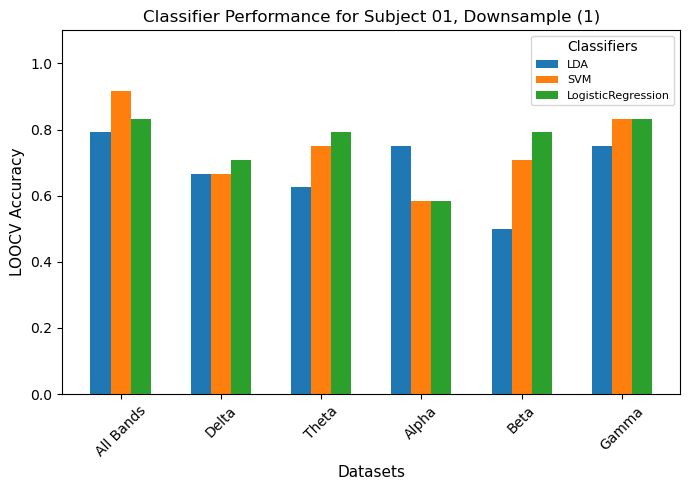

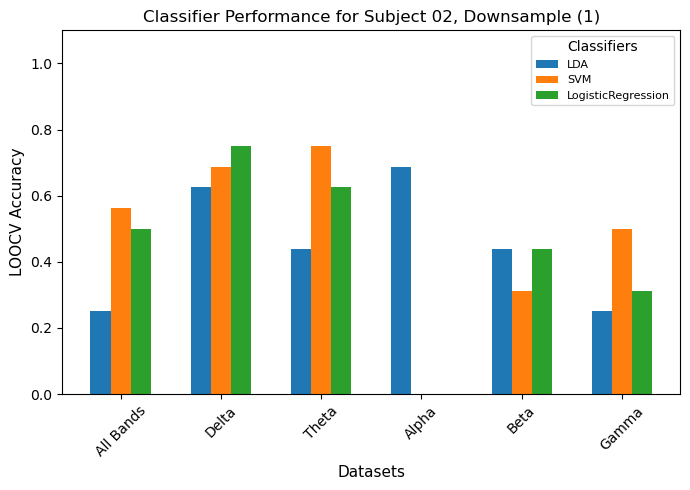

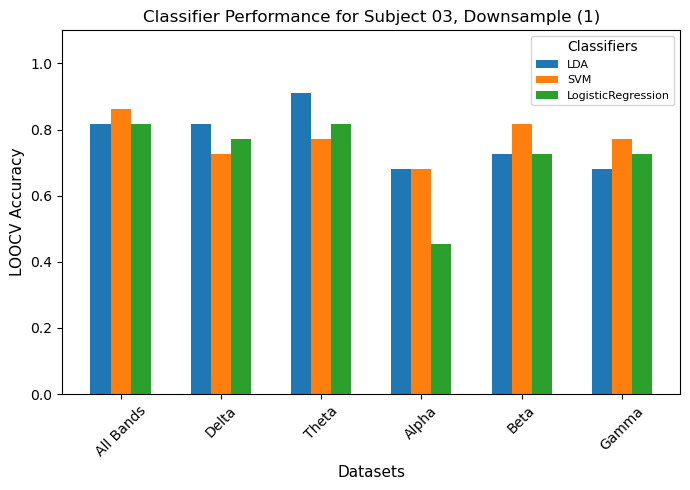

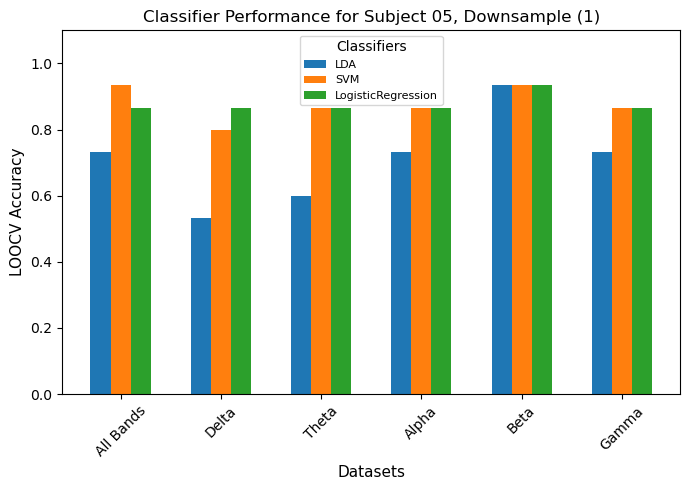

In [67]:
# Plot classifier results

# Function to plot classifier results for each subject separately
def plot_results_single_subject(results, downsample_rate):
    # Extract datasets and classifiers from the first subject's results
    datasets = list(results[0].keys())
    classifiers = list(results[0][datasets[0]].keys())
    bar_width = 0.2  # Width of each bar
    x = np.arange(len(datasets))  # Position of datasets on x-axis

    # Plot results for each subject separately
    for subject_idx, subject_results in enumerate(results):
        # Prepare data for plotting
        accuracies = np.array([[subject_results[dataset][clf] for clf in classifiers] for dataset in datasets])

        # Plot bars for each classifier
        plt.figure(figsize=(7, 5))
        for i, clf in enumerate(classifiers):
            plt.bar(x + i * bar_width, accuracies[:, i], width=bar_width, label=clf)

        # Add labels, title, and legend
        plt.xlabel("Datasets", fontsize=11)
        plt.ylabel("LOOCV Accuracy", fontsize=11)
        plt.title(f"Classifier Performance for Subject {subjects[subject_idx]}, Downsample ({downsample_rate})", fontsize=12)
        plt.xticks(x + bar_width * (len(classifiers) - 1) / 2, datasets, rotation=45, fontsize=10)
        plt.ylim(0, 1.1)  # Accuracy ranges from 0 to 1
        plt.legend(title="Classifiers", fontsize=8)
        plt.tight_layout()
        plt.show()

# Plot results 
## DOWNSAMPLING 1 (NO DOWNSAMPLING)
plot_results_single_subject(results, 1)

### 4. Add Additional Preprocessing Techniques

e.g., downsampling, ICA, using different filter types, etc. 

See its effect on the LOOCV accuracies. 

#### Add Downsampling

Experiment with downsampling with rates 2, 5, and 10. Downsampling rate 1 (no downsampling) is already plotted in the previous section. 

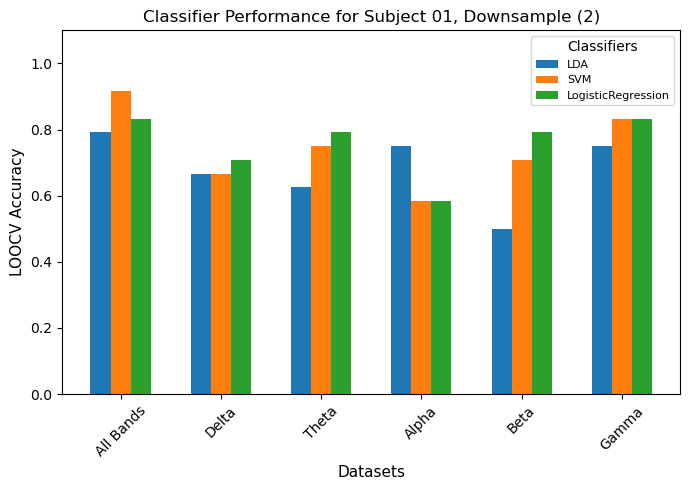

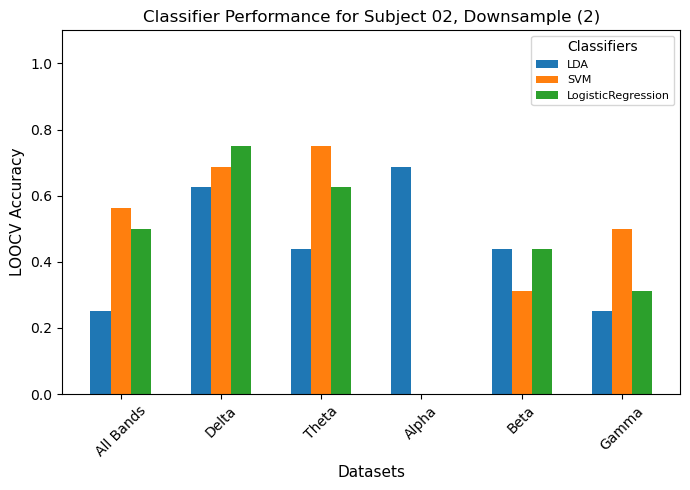

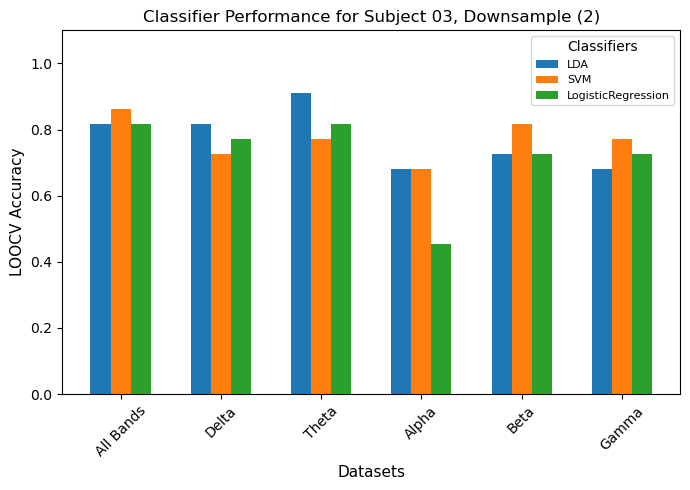

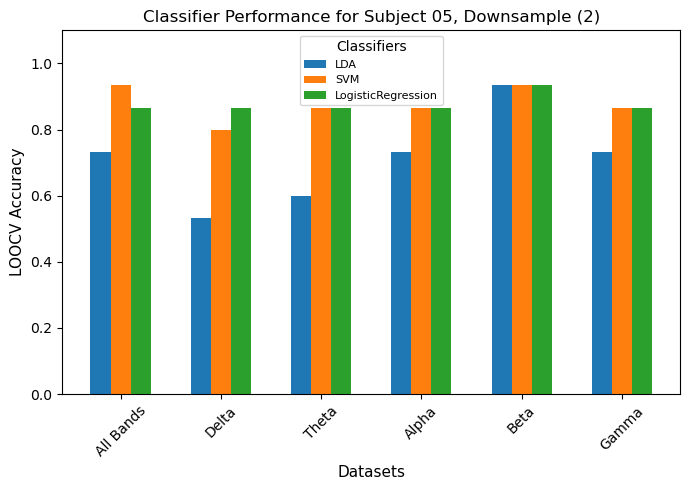

In [70]:
## DOWNSAMPLE 2
plot_results_single_subject(results, 2)

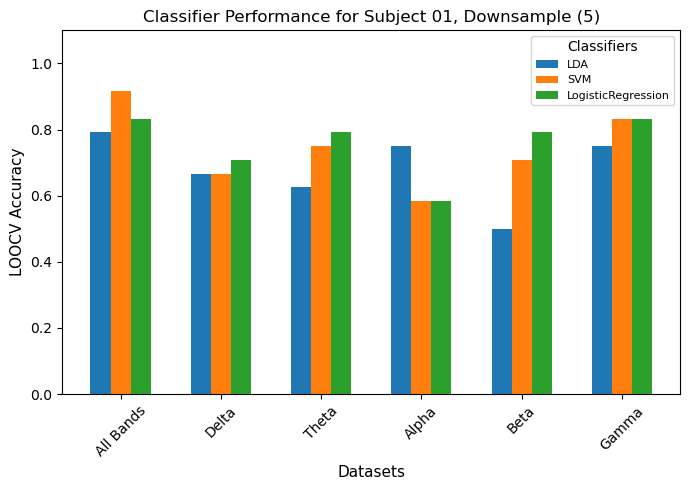

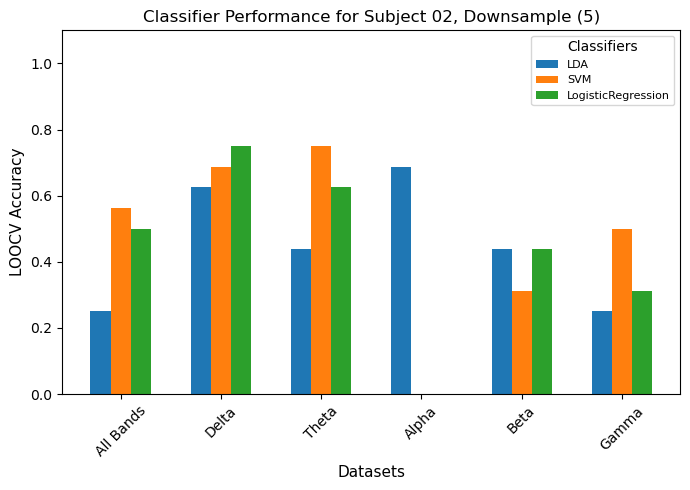

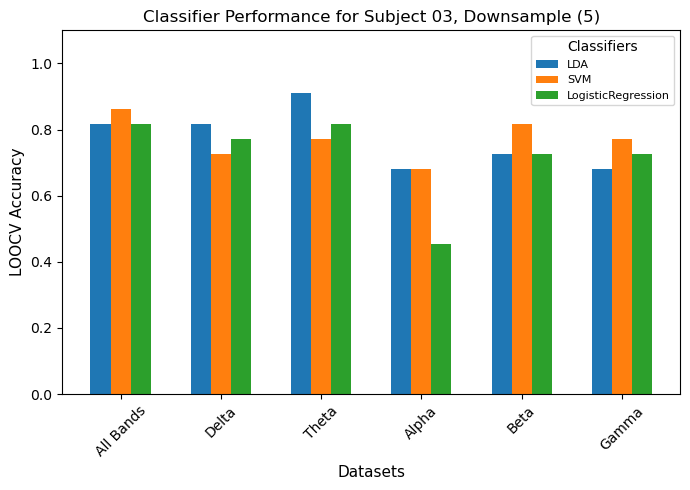

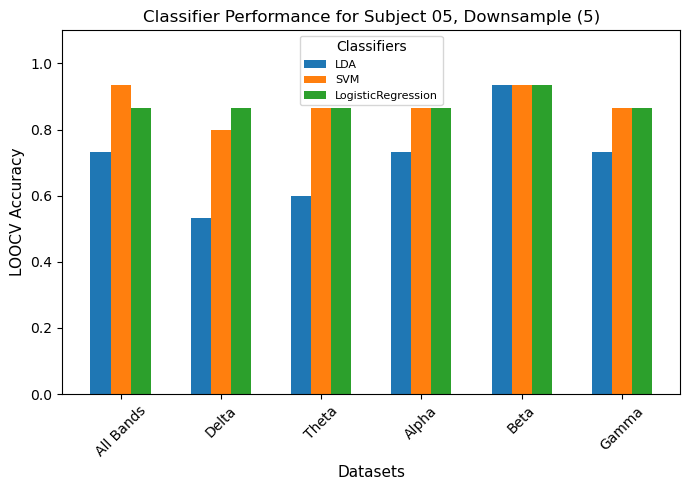

In [71]:
## DOWNSAMPLE 5
plot_results_single_subject(results, 5)

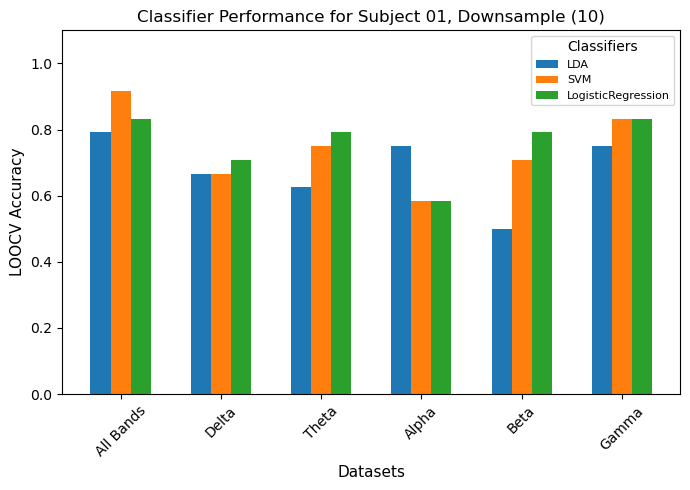

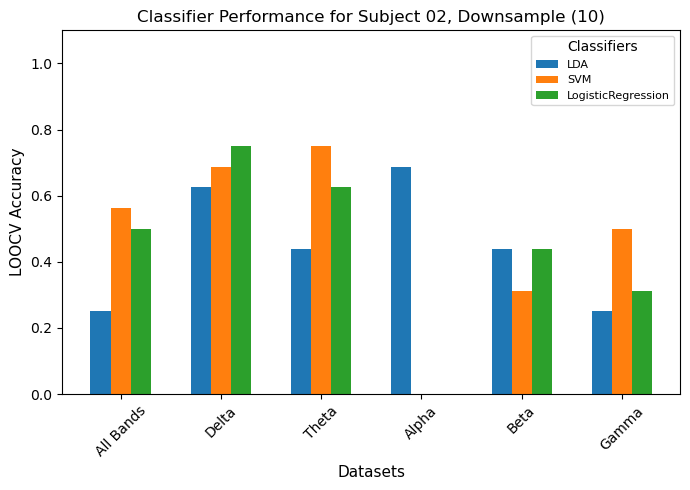

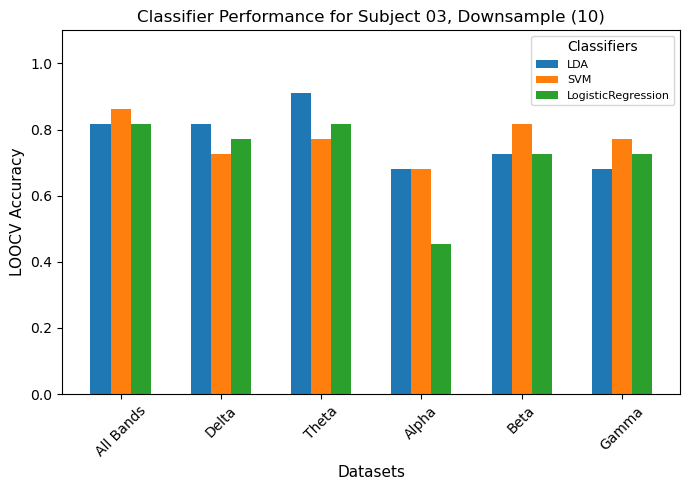

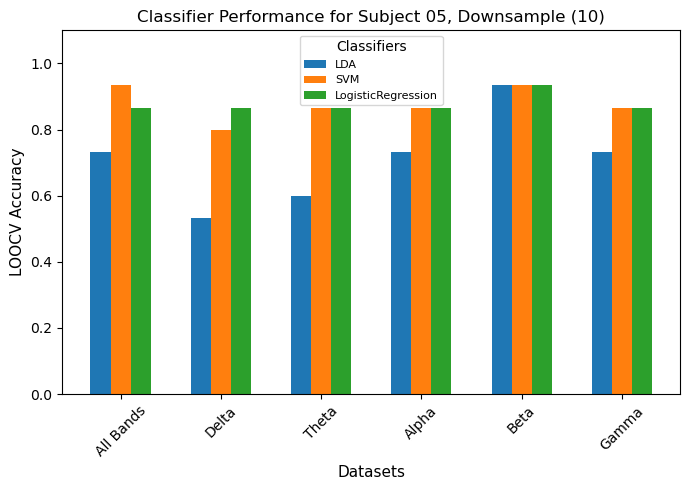

In [72]:
## DOWNSAMPLE 10
plot_results_single_subject(results, 10)

In [73]:
# TODO: Different filter types or different bandpass filtering

In [74]:
# TODO: Different feature types

In [75]:
# TODO: Different feature sets (linear and nonlinear - MFCC features, etc.)

In [ ]:
# TODO: Use ICA

## Multi-Subject Analysis

Do analysis on ALL subjects. Run on the file `S{s}_F_CL_Sil_50_100.mat` for all sujects `s`. Average the results over the subjects. 

In [76]:
def processAllSubjs(downsample_rate=1):
    all_results = {}
    sampling_rate = 256
    for s in [f"{i:02}" for i in range(1, 21)]:
        if s in ['04', '07', '13', '14']:
            continue
        file_path = f'Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S{s}_F_CL_Sil_50_100.mat'
        easy_trials, hard_trials = extract_trials(file_path, downsample_rate=downsample_rate)
        print(f'Subject {s} epoched')
    
        band_data = freq_bands(easy_trials, hard_trials, downsample_rate)
        
        X_all_bands, y_all_bands = prepare_all_bands_data(band_data)
        
        X_individual_bands, y_individual_bands = prepare_single_band_data(band_data)
    
        X_datasets = {"All Bands": (X_all_bands, y_all_bands)}
        for band, X in X_individual_bands.items():
            X_datasets[band] = (X, y_individual_bands[band])
        
        results = evaluate_classifiers(X_datasets, classifiers)
        all_results[s] = results
        print(f"Subject {s} all bands LDA - {results['All Bands']['LDA']}")
    return all_results

def getAvgAllSubjs(all_results):
    all_results_array = np.zeros((len(all_results), 18))
    for i, s in enumerate(all_results):
        j = 0
        for b in all_results[s]:
            for c in all_results[s][b]:
                all_results_array[i, j] = all_results[s][b][c]
                j += 1
    
    results_avg = {}
    j = 0
    for d in all_results['01']:
        results_avg[d] = {}
        for c in classifiers:
            results_avg[d][c] = all_results_array.mean(axis=0)[j]
            j += 1
    return results_avg

In [77]:
# Function to plot classifier results
def plot_results_across_subjects(results, downsample_rate):
    datasets = list(results.keys())
    classifiers = list(next(iter(results.values())).keys())
    
    # Prepare data for plotting
    accuracies = np.array([[results[dataset][clf] for clf in classifiers] for dataset in datasets])
    bar_width = 0.2  # Width of each bar
    x = np.arange(len(datasets))  # Position of datasets on x-axis

    # Plot bars for each classifier
    plt.figure(figsize=(5, 5))
    for i, clf in enumerate(classifiers):
        plt.bar(x + i * bar_width, accuracies[:, i], width=bar_width, label=clf)

    # Add labels, title, and legend
    plt.xlabel("Datasets", fontsize=11)
    plt.ylabel("LOOCV Accuracy", fontsize=11)
    plt.title(f"Classifier Performance Across All Subjects, Downsample ({downsample_rate})", fontsize=12)
    plt.xticks(x + bar_width, datasets, rotation=45, fontsize=10)
    plt.ylim(0, 1.1)  # Accuracy ranges from 0 to 1
    plt.legend(title="Classifiers", fontsize=8)
    plt.tight_layout()
    plt.show()

Subject 01 epoched
Subject 01 all bands LDA - 0.75
Subject 02 epoched
Subject 02 all bands LDA - 0.8125
skipped trial
skipped trial
Subject 03 epoched
Subject 03 all bands LDA - 1.0
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 05 epoched
Subject 05 all bands LDA - 1.0
Subject 06 epoched
Subject 06 all bands LDA - 0.7391304347826086
skipped trial
Subject 08 epoched
Subject 08 all bands LDA - 0.6956521739130435
skipped trial
Subject 09 epoched
Subject 09 all bands LDA - 0.6086956521739131
Subject 10 epoched
Subject 10 all bands LDA - 0.8125
skipped trial
Subject 11 epoched
Subject 11 all bands LDA - 0.6956521739130435
Subject 12 epoched
Subject 12 all bands LDA - 0.7083333333333334
Subject 15 epoched
Subject 15 all bands LDA - 1.0
skipped trial
skipped trial
skipped trial
Subject 16 epoched
Subject 16 all bands LDA - 0.42857142857142855
Subject 17 epoched
Subject 17 all bands LDA - 0.8823529411764706
skipped trial

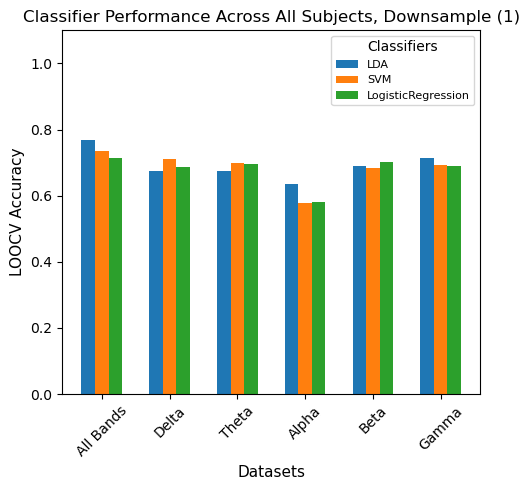

In [79]:
## DOWNSAMPLE 1 (NO DOWNSAMPLING)
all_results = processAllSubjs(downsample_rate=1)
results_avg = getAvgAllSubjs(all_results)
plot_results_across_subjects(results_avg, 1)

### Add Downsampling

Experiment with downsampling with rates 2, 5, and 10. Downsampling rate 1 (keep all original data) is already plotted in the previous section.

Subject 01 epoched
Subject 01 all bands LDA - 0.625
Subject 02 epoched
Subject 02 all bands LDA - 0.75
skipped trial
skipped trial
Subject 03 epoched
Subject 03 all bands LDA - 1.0
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 05 epoched
Subject 05 all bands LDA - 0.8666666666666667
Subject 06 epoched
Subject 06 all bands LDA - 0.8260869565217391
skipped trial
Subject 08 epoched
Subject 08 all bands LDA - 0.5652173913043478
skipped trial
Subject 09 epoched
Subject 09 all bands LDA - 0.6956521739130435
Subject 10 epoched
Subject 10 all bands LDA - 0.8125
skipped trial
Subject 11 epoched
Subject 11 all bands LDA - 0.5217391304347826
Subject 12 epoched
Subject 12 all bands LDA - 0.75
Subject 15 epoched
Subject 15 all bands LDA - 0.9411764705882353
skipped trial
skipped trial
skipped trial
Subject 16 epoched
Subject 16 all bands LDA - 0.5
Subject 17 epoched
Subject 17 all bands LDA - 0.8823529411764706
skipped trial


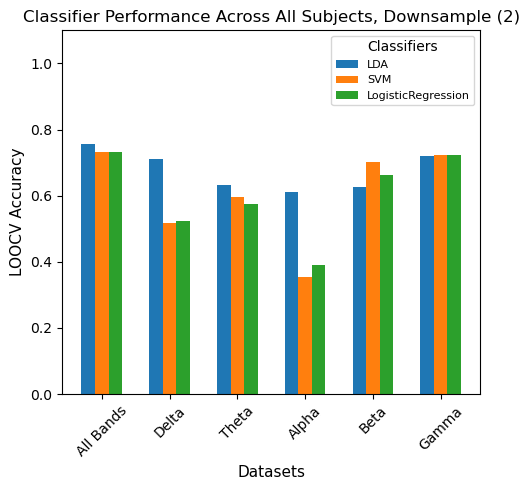

In [80]:
## DOWNSAMPLE 2

all_results = processAllSubjs(downsample_rate=2)
results_avg = getAvgAllSubjs(all_results)
plot_results_across_subjects(results_avg, 2)

Subject 01 epoched
Subject 01 all bands LDA - 0.625
Subject 02 epoched
Subject 02 all bands LDA - 0.4375
skipped trial
skipped trial
Subject 03 epoched
Subject 03 all bands LDA - 0.8636363636363636
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 05 epoched
Subject 05 all bands LDA - 0.8
Subject 06 epoched
Subject 06 all bands LDA - 0.4782608695652174
skipped trial
Subject 08 epoched
Subject 08 all bands LDA - 0.6956521739130435
skipped trial
Subject 09 epoched
Subject 09 all bands LDA - 0.6956521739130435
Subject 10 epoched
Subject 10 all bands LDA - 0.5
skipped trial
Subject 11 epoched
Subject 11 all bands LDA - 0.782608695652174
Subject 12 epoched
Subject 12 all bands LDA - 0.625
Subject 15 epoched
Subject 15 all bands LDA - 0.8235294117647058
skipped trial
skipped trial
skipped trial
Subject 16 epoched
Subject 16 all bands LDA - 0.5714285714285714
Subject 17 epoched
Subject 17 all bands LDA - 0.8235294117647058


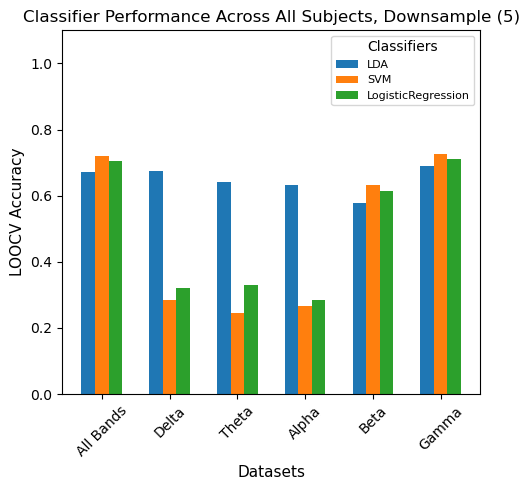

In [81]:
## DOWNSAMPLE 5

all_results = processAllSubjs(downsample_rate=5)
results_avg = getAvgAllSubjs(all_results)
plot_results_across_subjects(results_avg, 5)

Subject 01 epoched
Subject 01 all bands LDA - 0.9166666666666666
Subject 02 epoched
Subject 02 all bands LDA - 0.375
skipped trial
skipped trial
Subject 03 epoched
Subject 03 all bands LDA - 0.5454545454545454
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 05 epoched
Subject 05 all bands LDA - 0.8
Subject 06 epoched
Subject 06 all bands LDA - 0.4782608695652174
skipped trial
Subject 08 epoched
Subject 08 all bands LDA - 0.6521739130434783
skipped trial
Subject 09 epoched
Subject 09 all bands LDA - 0.5652173913043478
Subject 10 epoched
Subject 10 all bands LDA - 0.75
skipped trial
Subject 11 epoched
Subject 11 all bands LDA - 0.4782608695652174
Subject 12 epoched
Subject 12 all bands LDA - 0.75
Subject 15 epoched
Subject 15 all bands LDA - 0.8235294117647058
skipped trial
skipped trial
skipped trial
Subject 16 epoched
Subject 16 all bands LDA - 0.7857142857142857
Subject 17 epoched
Subject 17 all bands LDA - 0.8235

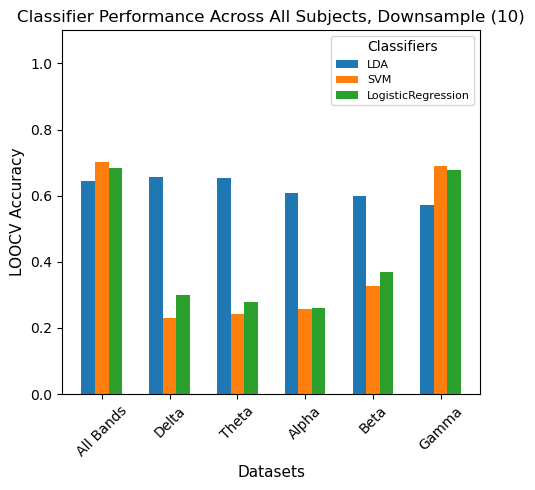

In [82]:
## DOWNSAMPLE 10

all_results = processAllSubjs(downsample_rate=10)
results_avg = getAvgAllSubjs(all_results)
plot_results_across_subjects(results_avg, 10)